# LegalBench-RAG Benchmark Evaluation

This notebook demonstrates how to evaluate retrieval systems using the **LegalBench-RAG** benchmark.

**LegalBench-RAG** is a specialized benchmark for evaluating Retrieval-Augmented Generation (RAG) systems in the legal domain.

## About LegalBench-RAG

Based on: *"LegalBench-RAG: A Benchmark for Retrieval-Augmented Generation in the Legal Domain"* (Pipitone & Houir Alami, 2024)

- **Full dataset**: 6,858 queries across 714 legal documents (79M+ characters)
- **Mini dataset**: 776 queries for faster iteration
- **4 subdatasets**: ContractNLI, CUAD, MAUD, PrivacyQA
- **Dual evaluation**: Document-level and snippet-level (character span) metrics

## What You'll Learn

0. **Prepare the dataset** - Automatically merge benchmark files into unified format
1. Load and explore the LegalBench-RAG dataset
2. Understand document-level vs. snippet-level evaluation
3. Run comprehensive benchmarks
4. Analyze results across different legal domains
5. Compare performance to published baselines
6. Visualize retrieval performance


In [1]:
import sys
sys.path.append('..')

import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm

# Import our modules
from src.data.legalbench_loader import LegalBenchRAGLoader, LegalBenchQuery
from src.retrieval.retriever import LegalRetriever, load_retriever_from_config
from src.evaluation.legalbench_eval import (
    evaluate_legalbench_rag,
    calculate_snippet_precision_at_k,
    calculate_snippet_recall_at_k,
    calculate_document_precision_at_k,
    calculate_document_recall_at_k
)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports complete!")

✅ Imports complete!


## 0. Dataset Preparation

Before running the benchmark, we need to prepare the LegalBench-RAG dataset. 

Download from: https://www.dropbox.com/scl/fo/r7xfa5i3hdsbxex1w6amw/AID389Olvtm-ZLTKAPrw6k4?rlkey=5n8zrbk4c08lbit3iiexofmwg&e=1&st=0hu354cq&dl=0

After downloading, place the dataset in `data/legalbench-rag/` (this notebook will handle the rest!)

The downloaded dataset contains 4 separate benchmark files (one per subdataset), but our loader expects a single unified `queries.json` file. This section automatically merges them.

In [2]:
# Check if queries.json exists, if not merge the benchmark files
data_dir = Path('../data/legalbench-rag')
queries_file = data_dir / 'queries.json'
benchmarks_dir = data_dir / 'benchmarks'

if not queries_file.exists():
    print("📦 Queries file not found. Preparing dataset from benchmark files...")
    print("=" * 80)
    
    # Dataset name mapping
    dataset_mapping = {
        'contractnli.json': 'ContractNLI',
        'cuad.json': 'CUAD',
        'maud.json': 'MAUD',
        'privacy_qa.json': 'PrivacyQA'
    }
    
    # Merge all benchmark files
    all_tests = []
    total_queries = 0
    
    for benchmark_file, dataset_name in dataset_mapping.items():
        file_path = benchmarks_dir / benchmark_file
        
        if file_path.exists():
            print(f"\nReading {benchmark_file}...")
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            tests = data.get('tests', [])
            
            # Add dataset source to each query
            for test in tests:
                test['dataset_source'] = dataset_name
            
            all_tests.extend(tests)
            total_queries += len(tests)
            print(f"  ✓ Loaded {len(tests)} queries from {dataset_name}")
        else:
            print(f"  ⚠ Warning: {benchmark_file} not found")
    
    # Create merged queries file
    merged_data = {'tests': all_tests}
    
    print(f"\n{'='*80}")
    print(f"Merging {total_queries} queries into queries.json...")
    
    with open(queries_file, 'w') as f:
        json.dump(merged_data, f, indent=2)
    
    print(f"✅ Dataset preparation complete!")
    print(f"   Created: {queries_file}")
    print(f"   Total queries: {total_queries}")
    print(f"   Breakdown:")
    for benchmark_file, dataset_name in dataset_mapping.items():
        file_path = benchmarks_dir / benchmark_file
        if file_path.exists():
            with open(file_path, 'r') as f:
                count = len(json.load(f).get('tests', []))
            print(f"     - {dataset_name}: {count} queries")
    print("=" * 80)
else:
    print("✅ Queries file already exists. Skipping dataset preparation.")
    print(f"   Location: {queries_file}")

✅ Queries file already exists. Skipping dataset preparation.
   Location: ../data/legalbench-rag/queries.json


## 1. Load and Explore the Dataset

First, let's load the LegalBench-RAG dataset and examine its structure.

In [3]:
# Load configuration
with open('../configs/legalbench_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Adjust paths for notebook (running from notebooks/ directory)
# Config paths are relative to project root, so prepend '../' 
config['corpus_dir'] = '../' + config['corpus_dir']
config['queries_file'] = '../' + config['queries_file']

print("LegalBench-RAG Configuration:")
print(f"  Corpus directory: {config['corpus_dir']}")
print(f"  Queries file: {config['queries_file']}")
print(f"  Using mini version: {config['use_mini']}")
print(f"  K-values for evaluation: {config['k_values']}")
print(f"  Minimum IoU for snippets: {config['min_iou']}")

LegalBench-RAG Configuration:
  Corpus directory: ../data/legalbench-rag/corpus
  Queries file: ../data/legalbench-rag/queries.json
  Using mini version: False
  K-values for evaluation: [1, 2, 4, 8, 16, 32, 64]
  Minimum IoU for snippets: 0.5


In [4]:
# Initialize the loader
# Set use_mini=True for faster iteration, False for full benchmark
loader = LegalBenchRAGLoader(
    corpus_dir=config['corpus_dir'],
    queries_file=config['queries_file'],
    use_mini=True  # Change to False for full dataset
)

# Load queries
queries = loader.load_queries()

print(f"\n✅ Loaded {len(queries)} queries")

Loaded 776 queries from LegalBench-RAG

✅ Loaded 776 queries


In [5]:
# Get corpus statistics
stats = loader.get_corpus_statistics()

print("\nCorpus Statistics:")
print("="*60)
print(f"Total documents: {stats['num_documents']}")
print(f"Total characters: {stats['total_characters']:,}")
print(f"Total queries: {stats['num_queries']}")
print(f"Version: {stats['version']}")
print(f"\nQueries by dataset:")
for dataset, count in stats['queries_by_dataset'].items():
    print(f"  {dataset}: {count} queries")
print("="*60)


Corpus Statistics:
Total documents: 714
Total characters: 79,704,214
Total queries: 776
Version: mini

Queries by dataset:
  ContractNLI: 194 queries
  CUAD: 194 queries
  MAUD: 194 queries
  PrivacyQA: 194 queries


### Example Query Exploration

In [6]:
# Examine a sample query
sample_query = queries[0]

print("Sample Query:")
print("="*80)
print(f"Query text: {sample_query.query[:200]}...")
print(f"\nDataset source: {sample_query.dataset_source}")
print(f"Number of ground truth snippets: {len(sample_query.snippets)}")
print(f"Relevant documents: {sample_query.get_document_ids()}")

# Show first snippet
if sample_query.snippets:
    snippet = sample_query.snippets[0]
    print(f"\nFirst snippet:")
    print(f"  File: {snippet.file_path}")
    print(f"  Character span: {snippet.span}")
    print(f"  Text preview: {snippet.answer[:150]}...")

Sample Query:
Query text: Consider the Mutual Non-Disclosure Agreement between Wayne Fueling Systems and Unknown Party; Does the document specify whether the Receiving Party is required to destroy or return Confidential Inform...

Dataset source: ContractNLI
Number of ground truth snippets: 1
Relevant documents: ['contractnli/wayne-fueling-systems-mutual-non-disclosure-agreement-final.txt']

First snippet:
  File: contractnli/wayne-fueling-systems-mutual-non-disclosure-agreement-final.txt
  Character span: (5950, 6237)
  Text preview: In any such case or upon any other termination of this Agreement, the Receiving Party will immediately: (i) return all Confidential Information disclo...


### Visualize Dataset Distribution

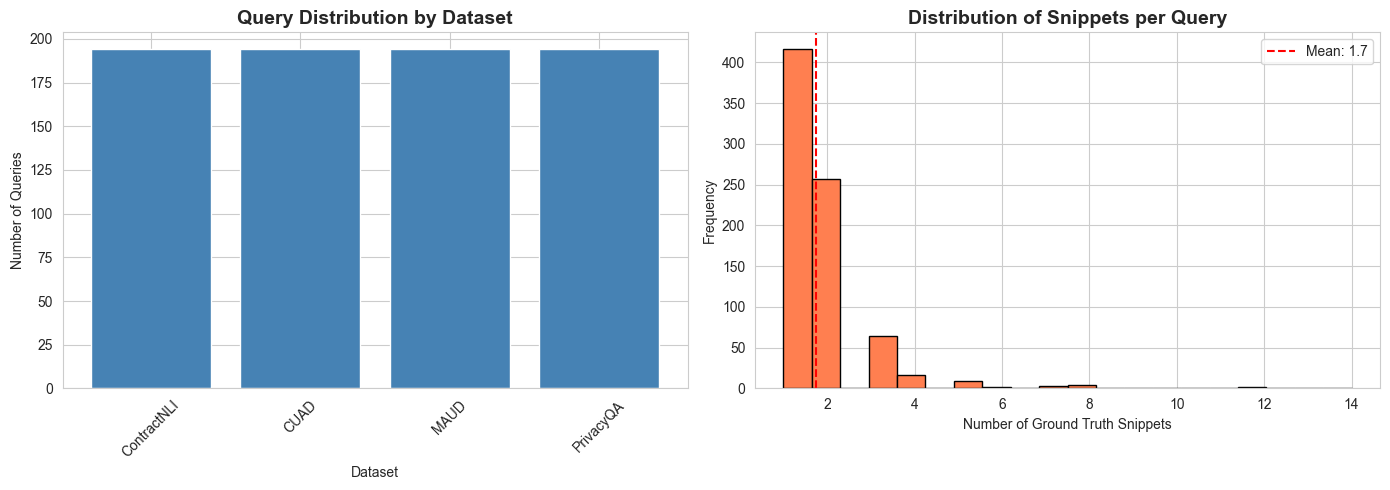


Snippet statistics:
  Mean snippets per query: 1.74
  Median snippets per query: 1
  Max snippets per query: 14


In [7]:
# Create distribution visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Query distribution by dataset
dataset_counts = stats['queries_by_dataset']
axes[0].bar(dataset_counts.keys(), dataset_counts.values(), color='steelblue')
axes[0].set_title('Query Distribution by Dataset', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Number of Queries')
axes[0].tick_params(axis='x', rotation=45)

# Snippets per query distribution
snippets_per_query = [len(q.snippets) for q in queries]
axes[1].hist(snippets_per_query, bins=20, color='coral', edgecolor='black')
axes[1].set_title('Distribution of Snippets per Query', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Ground Truth Snippets')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(snippets_per_query), color='red', linestyle='--', 
                label=f'Mean: {np.mean(snippets_per_query):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSnippet statistics:")
print(f"  Mean snippets per query: {np.mean(snippets_per_query):.2f}")
print(f"  Median snippets per query: {np.median(snippets_per_query):.0f}")
print(f"  Max snippets per query: {np.max(snippets_per_query)}")

## 2. Prepare the Retrieval System

Now we'll set up our retrieval system and index the LegalBench-RAG corpus.

In [8]:
# Load retrieval system configuration
retriever = load_retriever_from_config('../configs/retrieval_config.yaml')
print("✅ Retrieval system loaded")

Loading embedding model: sentence-transformers/all-mpnet-base-v2
Model loaded on mps
Embedding dimension: 768
✅ Retrieval system loaded


### Index the LegalBench-RAG Corpus

We need to index all documents from the corpus. This may take a few minutes.

In [9]:
# Check if index already exists - if so, load it instead of re-indexing
index_dir = Path('../data/legalbench_embeddings')
index_file = index_dir / 'faiss_index.faiss'

if index_file.exists():
    print(f"📂 Found existing index at {index_dir}")
    print("Loading saved index (this is much faster than re-indexing)...\n")
    
    retriever.load_index(str(index_dir))
    
    print(f"✅ Loaded index with {retriever.get_num_documents()} documents")
    print("\nℹ️  To force re-indexing, delete the index directory or set SKIP_INDEXING = False and run cells 16-18")
    
    # Set flag to skip indexing cells
    SKIP_INDEXING = True
else:
    print(f"📦 No existing index found at {index_dir}")
    print("Will create new index in the next cells...\n")
    SKIP_INDEXING = False

📂 Found existing index at ../data/legalbench_embeddings
Loading saved index (this is much faster than re-indexing)...

Using CPU index
Created IndexFlatIP index with dimension 768
Index loaded from ../data/legalbench_embeddings/faiss_index.faiss
Total documents in index: 326783
Documents loaded from ../data/legalbench_embeddings/documents.pkl
✅ Loaded index with 326783 documents

ℹ️  To force re-indexing, delete the index directory or set SKIP_INDEXING = False and run cells 16-18


In [10]:
# Skip if index already loaded
if SKIP_INDEXING:
    print("⏭️  Skipping document loading (index already loaded)")
else:
    # Gather all documents from the corpus
    corpus_path = Path(config['corpus_dir'])
    document_files = list(corpus_path.rglob('*.txt'))

    print(f"Found {len(document_files)} documents in corpus")

    # Load all documents
    documents = []
    for file_path in tqdm(document_files, desc="Loading documents"):
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
        
        # Store relative path for matching
        relative_path = str(file_path.relative_to(corpus_path))
        documents.append({
            'id': relative_path,
            'text': text,
            'metadata': {
                'source': relative_path,
                'file_path': relative_path
            }
        })

    print(f"\n✅ Loaded {len(documents)} documents")

⏭️  Skipping document loading (index already loaded)


In [11]:
# Skip if index already loaded
if SKIP_INDEXING:
    print("⏭️  Skipping indexing (index already loaded)")
else:
    # Index the documents with chunking
    print("Indexing documents (this may take a few minutes)...\n")
    retriever.index_documents(documents, chunk_documents=True)

    print(f"\n✅ Indexed {retriever.get_num_documents()} chunks from {len(documents)} documents")

⏭️  Skipping indexing (index already loaded)


In [12]:
# Skip if index already loaded (already saved)
if SKIP_INDEXING:
    print("⏭️  Index already loaded from disk, no need to save")
else:
    # Save the index for reuse
    index_dir = '../data/legalbench_embeddings'
    retriever.save_index(index_dir)
    print(f"✅ Index saved to {index_dir}")

⏭️  Index already loaded from disk, no need to save


## 3. Test Retrieval on Sample Queries

Before running the full benchmark, let's test retrieval on a few sample queries to see how it performs.

In [14]:
# Test on a sample query
test_query = queries[10]  # Pick an interesting query

print("Test Query:")
print("="*80)
print(f"Query: {test_query.query[:300]}...\n")
print(f"Dataset: {test_query.dataset_source}")
print(f"Ground truth documents: {test_query.get_document_ids()}")
print(f"Ground truth snippets: {len(test_query.snippets)}")

# Retrieve top results
results = retriever.retrieve(test_query.query, top_k=5)

print("\nTop 5 Retrieved Results:")
print("="*80)
for i, doc in enumerate(results, 1):
    source = doc.get('source', doc.get('file_path', 'Unknown'))
    is_relevant = '✓ RELEVANT' if source in test_query.get_document_ids() else '✗ Not relevant'
    
    print(f"\n{i}. Score: {doc['score']:.4f} {is_relevant}")
    print(f"   Source: {source}")
    print(f"   Text: {doc['text'][:200]}...")

Test Query:
Query: Consider ADVANIDE's Non-Disclosure Agreement; Does the document allow the Receiving Party to share some Confidential Information with their employees?...

Dataset: ContractNLI
Ground truth documents: ['contractnli/ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt']
Ground truth snippets: 2

Top 5 Retrieved Results:

1. Score: 0.7236 ✗ Not relevant
   Source: Unknown
   Text: The Company’s standard form confidentiality and assignment agreements have been made available to Parent. . To the knowledge of the Company, since January 1, 2019, there has been no unauthorized discl...

2. Score: 0.7104 ✗ Not relevant
   Source: Unknown
   Text: NON-DISCLOSURE AGREEMENT

R 2019/01

(Pls. fill in the form fields, print, sign and scan in color and email to your sales contact)

between AdvanIDe companies worldwide and AdvanIDe Europe GmbH, & Adv...

3. Score: 0.6966 ✗ Not relevant
   Source: Unknown
   Text:  All of your employees having access to our confidential and proprietary information 

## 4. Run Full LegalBench-RAG Evaluation

Now we'll run the complete benchmark evaluation with both document-level and snippet-level metrics.

In [15]:
# Run the full evaluation
# This will take a few minutes depending on dataset size
print("Running LegalBench-RAG evaluation...\n")

results = evaluate_legalbench_rag(
    retriever=retriever,
    loader=loader,
    k_values=config['k_values'],
    min_iou=config['min_iou'],
    evaluate_snippets=True  # Set to False to skip snippet evaluation for speed
)

print("\n✅ Evaluation complete!")

Running LegalBench-RAG evaluation...


Evaluating on 776 LegalBench-RAG queries...


Evaluating queries: 100%|██████████| 776/776 [00:27<00:00, 28.27it/s]


✅ Evaluation complete!


## 5. Analyze Results

Let's examine the benchmark results in detail.

In [16]:
# Display overall metrics
print("\n" + "="*100)
print("OVERALL RESULTS")
print("="*100)

print(f"\nEvaluated on {results['num_queries']} queries")

# Create results dataframe for easy viewing
metrics_data = []
for k in results['k_values']:
    row = {
        'k': k,
        'Doc Precision': f"{results['document_precision@k'][k]:.2%}",
        'Doc Recall': f"{results['document_recall@k'][k]:.2%}",
    }
    if 'snippet_precision@k' in results:
        row['Snippet Precision'] = f"{results['snippet_precision@k'][k]:.2%}"
        row['Snippet Recall'] = f"{results['snippet_recall@k'][k]:.2%}"
    metrics_data.append(row)

df_metrics = pd.DataFrame(metrics_data)
print("\n", df_metrics.to_string(index=False))


OVERALL RESULTS

Evaluated on 776 queries

  k Doc Precision Doc Recall Snippet Precision Snippet Recall
 1        55.93%     55.93%             0.39%          0.19%
 2        30.35%     60.70%             0.39%          0.27%
 4        16.24%     64.95%             0.29%          0.27%
 8         8.46%     67.65%             0.26%          0.27%
16         4.49%     71.91%             0.35%          0.27%
32         2.44%     78.22%             0.29%          0.27%
64         1.32%     84.41%             0.18%          0.27%


In [17]:
# Show per-dataset breakdown
if 'per_dataset' in results:
    print("\n" + "="*100)
    print("PER-DATASET BREAKDOWN")
    print("="*100)
    
    for dataset_name, dataset_results in results['per_dataset'].items():
        print(f"\n{dataset_name} ({dataset_results['count']} queries)")
        print("-"*100)
        
        # Show key metrics
        print(f"  Document P@1:  {dataset_results['document_precision@k'][1]:.2%}")
        print(f"  Document R@64: {dataset_results['document_recall@k'][64]:.2%}")
        
        if 'snippet_precision@k' in dataset_results:
            print(f"  Snippet P@1:   {dataset_results['snippet_precision@k'][1]:.2%}")
            print(f"  Snippet R@64:  {dataset_results['snippet_recall@k'][64]:.2%}")


PER-DATASET BREAKDOWN

ContractNLI (194 queries)
----------------------------------------------------------------------------------------------------
  Document P@1:  41.24%
  Document R@64: 76.80%
  Snippet P@1:   0.00%
  Snippet R@64:  0.00%

CUAD (194 queries)
----------------------------------------------------------------------------------------------------
  Document P@1:  79.90%
  Document R@64: 99.48%
  Snippet P@1:   0.00%
  Snippet R@64:  0.00%

MAUD (194 queries)
----------------------------------------------------------------------------------------------------
  Document P@1:  13.92%
  Document R@64: 61.34%
  Snippet P@1:   0.00%
  Snippet R@64:  0.00%

PrivacyQA (194 queries)
----------------------------------------------------------------------------------------------------
  Document P@1:  88.66%
  Document R@64: 100.00%
  Snippet P@1:   1.55%
  Snippet R@64:  1.06%


## 6. Compare to Published Baselines

The paper reports baseline results using the RCTS (Recursive Character Text Splitter) method.

In [18]:
# Baseline results from the paper (RCTS method, Table 5)
paper_baselines = {
    'PrivacyQA': {'P@1': 14.38, 'R@64': 84.19},
    'ContractNLI': {'P@1': 6.63, 'R@64': 61.72},
    'MAUD': {'P@1': 2.65, 'R@64': 28.28},
    'CUAD': {'P@1': 1.97, 'R@64': 74.70},
    'Overall': {'P@1': 6.41, 'R@64': 62.22}
}

# Compare our results to baselines
print("\n" + "="*100)
print("COMPARISON TO PAPER BASELINE (RCTS method)")
print("="*100)

comparison_data = []

# Overall comparison
our_p1 = results['document_precision@k'][1] * 100
our_r64 = results['document_recall@k'][64] * 100
baseline_p1 = paper_baselines['Overall']['P@1']
baseline_r64 = paper_baselines['Overall']['R@64']

comparison_data.append({
    'Dataset': 'Overall',
    'Our P@1': f"{our_p1:.2f}%",
    'Baseline P@1': f"{baseline_p1:.2f}%",
    'Diff P@1': f"{our_p1 - baseline_p1:+.2f}%",
    'Our R@64': f"{our_r64:.2f}%",
    'Baseline R@64': f"{baseline_r64:.2f}%",
    'Diff R@64': f"{our_r64 - baseline_r64:+.2f}%"
})

# Per-dataset comparison
if 'per_dataset' in results:
    for dataset_name in ['PrivacyQA', 'ContractNLI', 'MAUD', 'CUAD']:
        if dataset_name in results['per_dataset'] and dataset_name in paper_baselines:
            our_dataset = results['per_dataset'][dataset_name]
            our_p1 = our_dataset['document_precision@k'][1] * 100
            our_r64 = our_dataset['document_recall@k'][64] * 100
            baseline_p1 = paper_baselines[dataset_name]['P@1']
            baseline_r64 = paper_baselines[dataset_name]['R@64']
            
            comparison_data.append({
                'Dataset': dataset_name,
                'Our P@1': f"{our_p1:.2f}%",
                'Baseline P@1': f"{baseline_p1:.2f}%",
                'Diff P@1': f"{our_p1 - baseline_p1:+.2f}%",
                'Our R@64': f"{our_r64:.2f}%",
                'Baseline R@64': f"{baseline_r64:.2f}%",
                'Diff R@64': f"{our_r64 - baseline_r64:+.2f}%"
            })

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

print("\nNote: Positive differences indicate our system outperforms the baseline.")


COMPARISON TO PAPER BASELINE (RCTS method)

     Dataset Our P@1 Baseline P@1 Diff P@1 Our R@64 Baseline R@64 Diff R@64
    Overall  55.93%        6.41%  +49.52%   84.41%        62.22%   +22.19%
  PrivacyQA  88.66%       14.38%  +74.28%  100.00%        84.19%   +15.81%
ContractNLI  41.24%        6.63%  +34.61%   76.80%        61.72%   +15.08%
       MAUD  13.92%        2.65%  +11.27%   61.34%        28.28%   +33.06%
       CUAD  79.90%        1.97%  +77.93%   99.48%        74.70%   +24.78%

Note: Positive differences indicate our system outperforms the baseline.


## 7. Visualize Performance

Create comprehensive visualizations of the benchmark results.

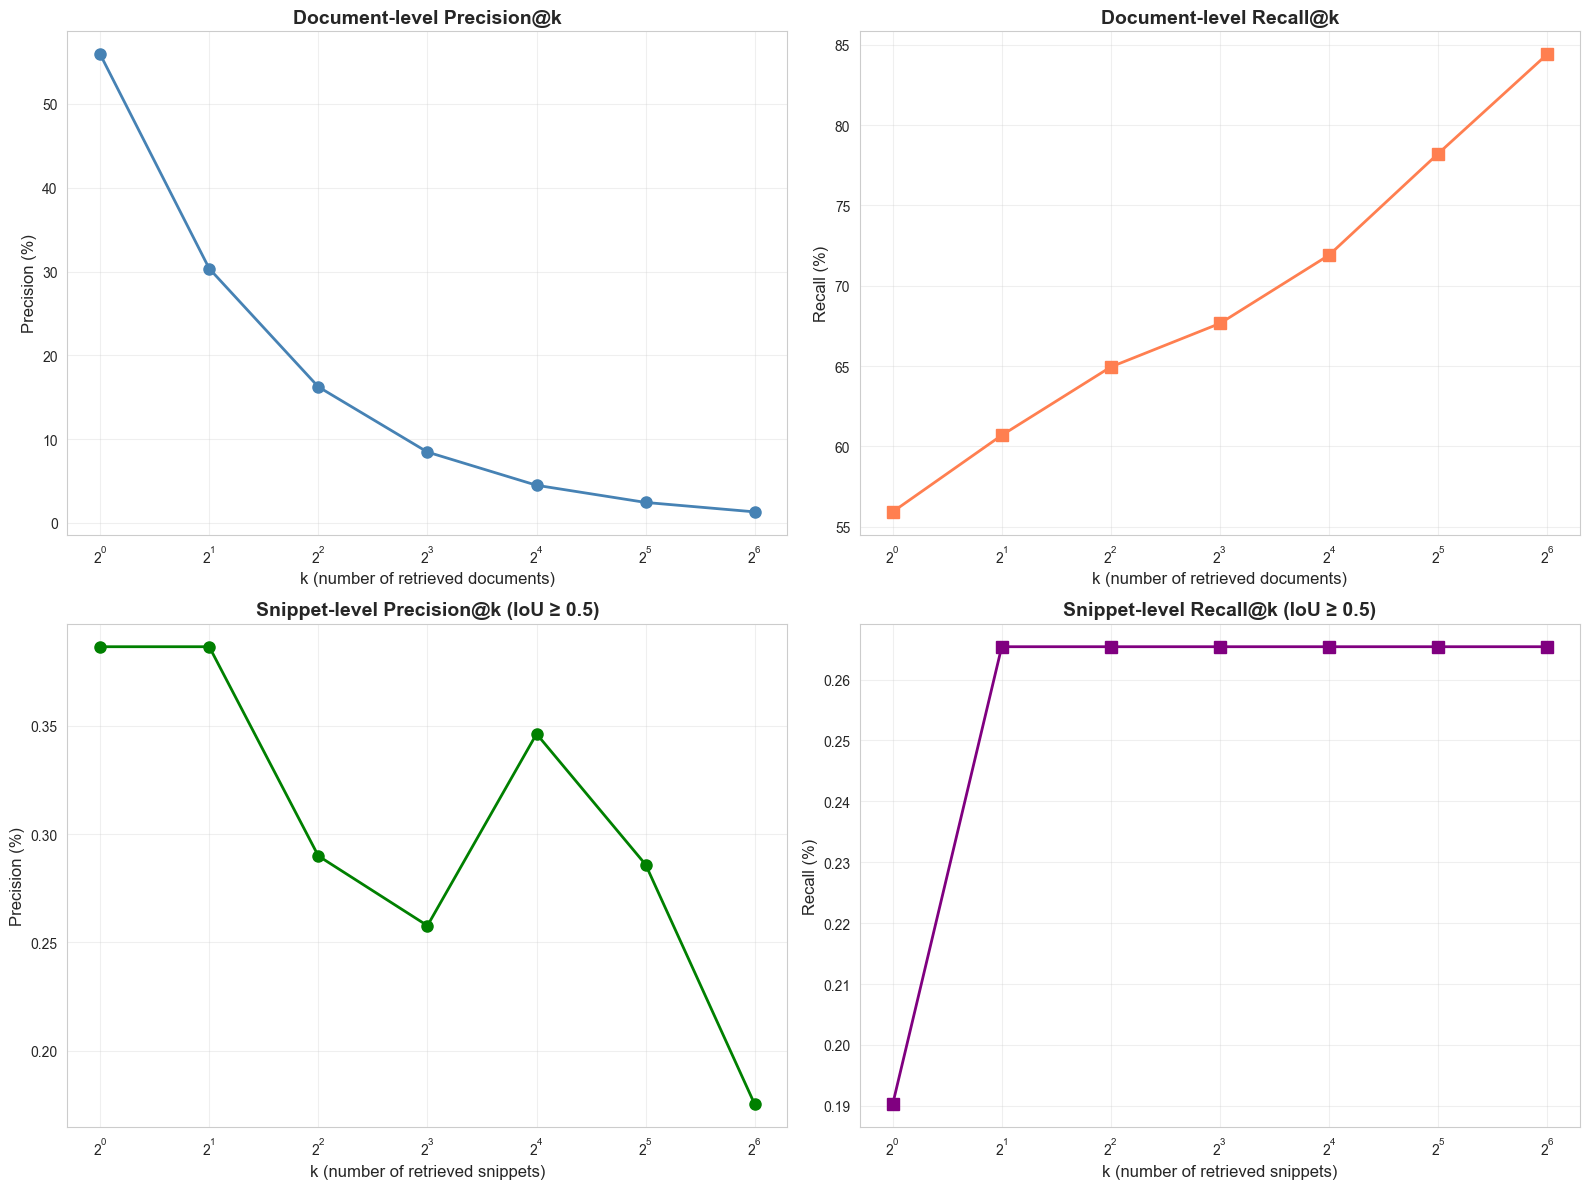

✅ Metrics curves saved to ../results/legalbench_metrics_curves.png


In [19]:
# Plot Precision and Recall curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

k_values = results['k_values']

# Document-level Precision@k
doc_prec = [results['document_precision@k'][k] * 100 for k in k_values]
axes[0, 0].plot(k_values, doc_prec, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_title('Document-level Precision@k', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('k (number of retrieved documents)', fontsize=12)
axes[0, 0].set_ylabel('Precision (%)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log', base=2)

# Document-level Recall@k
doc_rec = [results['document_recall@k'][k] * 100 for k in k_values]
axes[0, 1].plot(k_values, doc_rec, marker='s', linewidth=2, markersize=8, color='coral')
axes[0, 1].set_title('Document-level Recall@k', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('k (number of retrieved documents)', fontsize=12)
axes[0, 1].set_ylabel('Recall (%)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log', base=2)

# Snippet-level Precision@k (if available)
if 'snippet_precision@k' in results:
    snip_prec = [results['snippet_precision@k'][k] * 100 for k in k_values]
    axes[1, 0].plot(k_values, snip_prec, marker='o', linewidth=2, markersize=8, color='green')
    axes[1, 0].set_title(f'Snippet-level Precision@k (IoU ≥ {results["min_iou"]})', 
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('k (number of retrieved snippets)', fontsize=12)
    axes[1, 0].set_ylabel('Precision (%)', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xscale('log', base=2)

# Snippet-level Recall@k (if available)
if 'snippet_recall@k' in results:
    snip_rec = [results['snippet_recall@k'][k] * 100 for k in k_values]
    axes[1, 1].plot(k_values, snip_rec, marker='s', linewidth=2, markersize=8, color='purple')
    axes[1, 1].set_title(f'Snippet-level Recall@k (IoU ≥ {results["min_iou"]})', 
                        fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('k (number of retrieved snippets)', fontsize=12)
    axes[1, 1].set_ylabel('Recall (%)', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xscale('log', base=2)

plt.tight_layout()
plt.savefig('../results/legalbench_metrics_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Metrics curves saved to ../results/legalbench_metrics_curves.png")

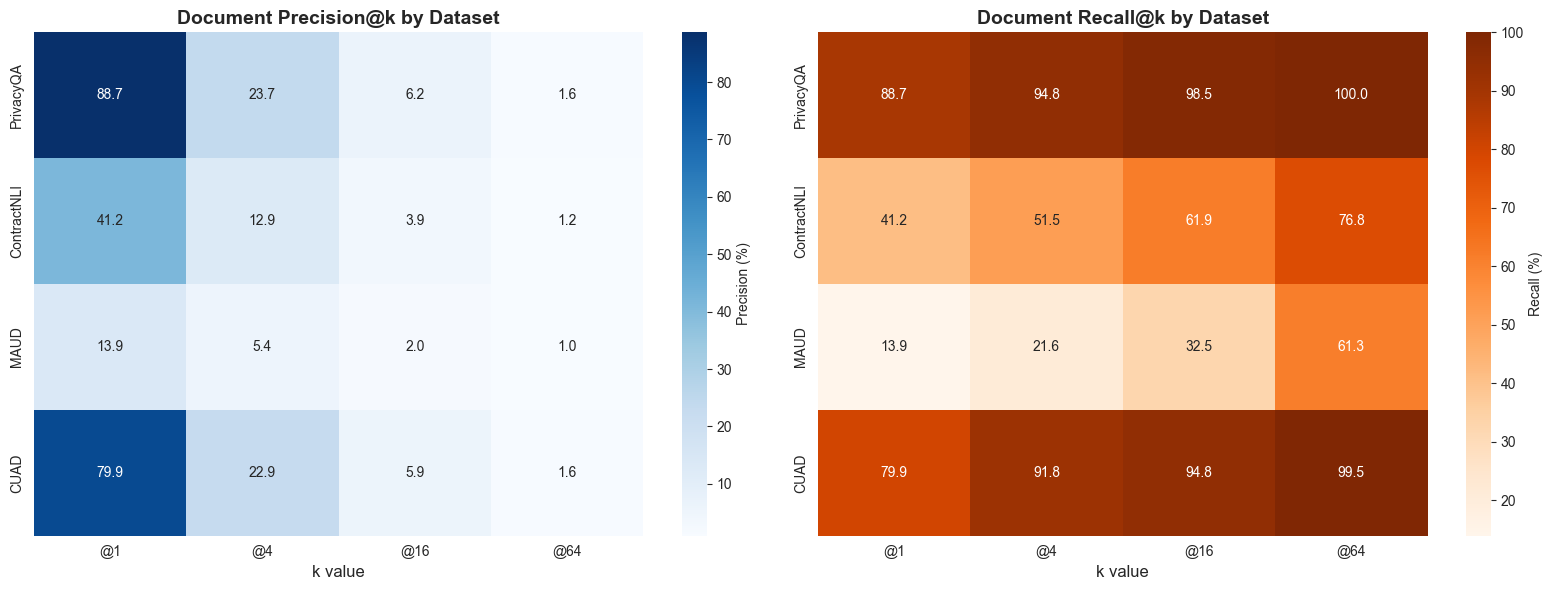

✅ Dataset heatmap saved to ../results/legalbench_dataset_heatmap.png


In [20]:
# Per-dataset comparison heatmap
if 'per_dataset' in results:
    datasets = ['PrivacyQA', 'ContractNLI', 'MAUD', 'CUAD']
    k_subset = [1, 4, 16, 64]  # Selected k values for visualization
    
    # Document-level heatmap
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Precision heatmap
    prec_data = []
    for dataset in datasets:
        if dataset in results['per_dataset']:
            row = [results['per_dataset'][dataset]['document_precision@k'][k] * 100 
                   for k in k_subset]
            prec_data.append(row)
    
    sns.heatmap(prec_data, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=[f'@{k}' for k in k_subset],
                yticklabels=datasets, ax=axes[0], cbar_kws={'label': 'Precision (%)'})
    axes[0].set_title('Document Precision@k by Dataset', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('k value', fontsize=12)
    
    # Recall heatmap
    rec_data = []
    for dataset in datasets:
        if dataset in results['per_dataset']:
            row = [results['per_dataset'][dataset]['document_recall@k'][k] * 100 
                   for k in k_subset]
            rec_data.append(row)
    
    sns.heatmap(rec_data, annot=True, fmt='.1f', cmap='Oranges',
                xticklabels=[f'@{k}' for k in k_subset],
                yticklabels=datasets, ax=axes[1], cbar_kws={'label': 'Recall (%)'})
    axes[1].set_title('Document Recall@k by Dataset', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('k value', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('../results/legalbench_dataset_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Dataset heatmap saved to ../results/legalbench_dataset_heatmap.png")

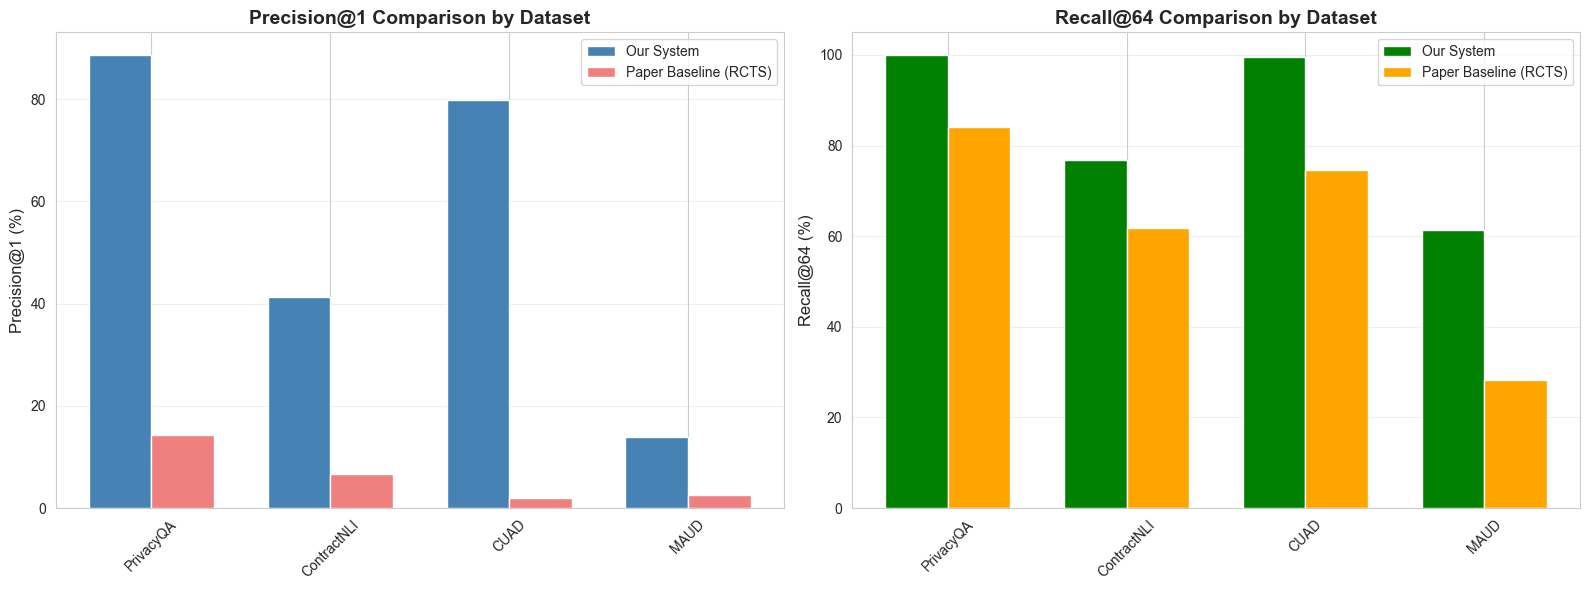

✅ Baseline comparison saved to ../results/legalbench_baseline_comparison.png


In [21]:
# Baseline comparison visualization
if 'per_dataset' in results:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    datasets_order = ['PrivacyQA', 'ContractNLI', 'CUAD', 'MAUD']
    
    # P@1 comparison
    our_p1_vals = []
    baseline_p1_vals = []
    for ds in datasets_order:
        if ds in results['per_dataset']:
            our_p1_vals.append(results['per_dataset'][ds]['document_precision@k'][1] * 100)
            baseline_p1_vals.append(paper_baselines[ds]['P@1'])
    
    x = np.arange(len(datasets_order))
    width = 0.35
    axes[0].bar(x - width/2, our_p1_vals, width, label='Our System', color='steelblue')
    axes[0].bar(x + width/2, baseline_p1_vals, width, label='Paper Baseline (RCTS)', color='lightcoral')
    axes[0].set_ylabel('Precision@1 (%)', fontsize=12)
    axes[0].set_title('Precision@1 Comparison by Dataset', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(datasets_order, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # R@64 comparison
    our_r64_vals = []
    baseline_r64_vals = []
    for ds in datasets_order:
        if ds in results['per_dataset']:
            our_r64_vals.append(results['per_dataset'][ds]['document_recall@k'][64] * 100)
            baseline_r64_vals.append(paper_baselines[ds]['R@64'])
    
    axes[1].bar(x - width/2, our_r64_vals, width, label='Our System', color='green')
    axes[1].bar(x + width/2, baseline_r64_vals, width, label='Paper Baseline (RCTS)', color='orange')
    axes[1].set_ylabel('Recall@64 (%)', fontsize=12)
    axes[1].set_title('Recall@64 Comparison by Dataset', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(datasets_order, rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/legalbench_baseline_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Baseline comparison saved to ../results/legalbench_baseline_comparison.png")

## 8. Save Results

Save the complete results to JSON for future reference.

In [22]:
# Save results to JSON
import os

results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

results_file = results_dir / 'legalbench_evaluation_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Results saved to {results_file}")

# Also save a human-readable summary
summary_file = results_dir / 'legalbench_summary.txt'
with open(summary_file, 'w') as f:
    f.write("LegalBench-RAG Evaluation Summary\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Number of queries: {results['num_queries']}\n")
    f.write(f"Version: {'mini' if loader.use_mini else 'full'}\n\n")
    
    f.write("Overall Metrics:\n")
    f.write("-" * 80 + "\n")
    for k in [1, 4, 16, 64]:
        f.write(f"Document Precision@{k:2d}: {results['document_precision@k'][k]:.2%}\n")
        f.write(f"Document Recall@{k:2d}:    {results['document_recall@k'][k]:.2%}\n")
    
    if 'per_dataset' in results:
        f.write("\nPer-Dataset Results:\n")
        f.write("-" * 80 + "\n")
        for dataset, ds_results in results['per_dataset'].items():
            f.write(f"\n{dataset} ({ds_results['count']} queries):\n")
            f.write(f"  P@1:  {ds_results['document_precision@k'][1]:.2%}\n")
            f.write(f"  R@64: {ds_results['document_recall@k'][64]:.2%}\n")

print(f"✅ Summary saved to {summary_file}")

✅ Results saved to ../results/legalbench_evaluation_results.json
✅ Summary saved to ../results/legalbench_summary.txt


## Summary and Next Steps

### What We Accomplished:

1. ✅ Loaded and explored the LegalBench-RAG benchmark dataset
2. ✅ Indexed the legal document corpus with our retrieval system
3. ✅ Evaluated retrieval performance with document-level and snippet-level metrics
4. ✅ Compared results against published baselines
5. ✅ Created comprehensive visualizations
6. ✅ Saved results for future reference

### Key Insights:

- **Document-level metrics** measure whether the correct documents are retrieved
- **Snippet-level metrics** (with IoU threshold) measure whether the exact text spans are found
- Different legal domains have varying difficulty levels (PrivacyQA is easiest, MAUD is hardest)
- The benchmark enables rigorous evaluation of RAG systems for legal applications

### Next Steps:

1. **Improve chunking strategy**: Experiment with different chunk sizes and overlap
2. **Test different embeddings**: Try legal-domain-specific embedding models
3. **Add re-ranking**: Implement a second-stage re-ranker for better precision
4. **Integrate with Self-RAG**: Use the critic model to improve retrieval quality
5. **Error analysis**: Deep dive into failed queries to understand limitations

### Resources:

- Paper: *LegalBench-RAG: A Benchmark for Retrieval-Augmented Generation in the Legal Domain*
- Dataset: https://github.com/zeroentropy-cc/legalbenchrag
- Next notebook: `10_advanced_retrieval.ipynb` (to be created)